In [35]:
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# PyTorch related imports would go here

# Original Data

In [36]:
df = pd.read_csv('PM25-Speciated/Speciate_Raw_V07052024.csv')

In [69]:
df

,code,name,mass,cat1,cat2,cat3,species,weight%
0,10,Overall Composite,55.476002,Miscellaneous,Miscellaneous,Miscellaneous,Ammonium,0.023000
1,10,Overall Composite,55.476002,Miscellaneous,Miscellaneous,Miscellaneous,Potassium,1.843000
2,10,Overall Composite,55.476002,Miscellaneous,Miscellaneous,Miscellaneous,Selenium,0.025000
3,10,Overall Composite,55.476002,Miscellaneous,Miscellaneous,Miscellaneous,Silicon,7.736000
4,10,Overall Composite,55.476002,Miscellaneous,Miscellaneous,Miscellaneous,Sodium,1.377000
...,...,...,...,...,...,...,...,...
80895,SUGP02,Sugar Cane Pre-Harvest Burning Mexico,100.000000,Combustion,Biomass Burning; Agriculture,Pre-harvest Sugar Cane,Potassium,17.899160
80896,SUGP02,Sugar Cane Pre-Harvest Burning Mexico,100.000000,Combustion,Biomass Burning; Agriculture,Pre-harvest Sugar Cane,Sodium,0.168067
80897,SUGP02,Sugar Cane Pre-Harvest Burning Mexico,100.000000,Combustion,Biomass Burning; Agriculture,Pre-harvest Sugar Cane,Sulfate,3.361345
80898,SUGP02,Sugar Cane Pre-Harvest Burning Mexico,100.000000,Combustion,Biomass Burning; Agriculture,Pre-harvest Sugar Cane,Ammonium,2.184874


In [38]:
pivot_df = df.pivot_table(index=['code', 'name'], columns='species', values='weight%', aggfunc='first').reset_index()
# Fill NaN values with 0 (or any other value you prefer)
pivot_df = pivot_df.fillna(0)

In [70]:
pivot_df

species,code,name,Aluminum,Ammonium,Antimony,Arsenic,Bromine,Cadmium,Calcium,Calcium ion,...,Sodium,Sodium ion,Sulfate,Sulfur,Tin,Vanadium,Zinc,Zirconium,cluster_kmeans,assigned_profile
0,00000C,Overall Composite,4.079000,0.030000,0.806000,1.118000,0.0,0.285000,2.804000,0.0,...,1.577000,0.00000,5.030000,2.457000,0.103000,0.059000,2.235000,0.004000,153,0
1,10,Overall Composite,3.819000,0.023000,0.809000,1.410000,0.0,0.385000,2.399000,0.0,...,1.377000,0.00000,5.046000,2.632000,0.114000,0.058000,2.218000,0.002000,153,0
2,100CROC,Onroad Gasoline Cold Start,0.000000,0.430694,0.000000,0.000000,0.0,0.000000,0.387691,0.0,...,0.005178,0.00000,0.945113,0.000000,0.000000,0.000000,0.078439,0.000000,54,1
3,101CROC,Onroad Gasoline Running,0.323953,2.778929,0.000000,0.000000,0.0,0.000000,1.443041,0.0,...,0.039129,0.00000,7.187084,0.000000,0.000000,0.000000,0.592782,0.000000,54,1
4,102CROC,Onroad Diesel Non-DPF Idle,0.060154,1.739422,0.000000,0.000000,0.0,0.000000,0.584029,0.0,...,0.307717,0.00000,5.266531,0.000000,0.000000,0.000000,0.000000,0.000000,54,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3800,95806,Peat Fire-Smoldering-Minnesota AE6,0.000376,0.107249,0.000000,0.000905,0.0,0.000000,0.000000,0.0,...,0.000000,0.00000,0.428752,0.283134,0.000000,0.000266,0.000000,0.000063,54,1
3801,95807,Forest Fire Understory-Flaming-Minnesota AE6,0.000000,0.059422,0.034348,0.001050,0.0,0.031667,0.000000,0.0,...,0.000000,0.00000,0.318718,0.211847,0.000000,0.005668,0.035434,0.000000,54,1
3802,95808,Forest Fire Understory-Smoldering-Minnesota AE6,0.000000,0.057489,0.004902,0.000693,0.0,0.003139,0.032457,0.0,...,0.051420,0.07137,0.512190,0.281013,0.001126,0.000298,0.005076,0.000067,54,1
3803,95809,Grass Fire-Field-Kansas AE6,0.039424,0.159261,0.002697,0.001284,0.0,0.001939,0.790562,0.0,...,0.031122,0.00000,0.828073,0.382831,0.004751,0.000134,0.040129,0.000624,54,1


# Clustering

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from us import states
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [41]:
state_names = [state.name.lower() for state in states.STATES]
state_abbrs = [state.abbr for state in states.STATES]
city_df = pd.read_csv('PM25-Speciated/worldcities.csv')
city_names = city_df['city_ascii'].str.lower().tolist()  # First column
country_names = city_df['country'].str.lower().tolist()  # First column

In [42]:
stop_words = TfidfVectorizer(stop_words='english').get_stop_words()
stop_words = list(list(stop_words)+ city_names + country_names + state_names + state_abbrs)

In [43]:
vectorizer = TfidfVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(pivot_df['name'].str.replace('[-,%/0-9&)(]', '', regex=True).str.lower())

In [98]:
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto')
pivot_df['cluster_kmeans'] = kmeans.fit_predict(X)

In [99]:
for cluster_num in range(num_clusters):
    print(f"\nCluster {cluster_num}:")
    cluster_texts = pivot_df[pivot_df['cluster_kmeans'] == cluster_num]['name']
    for text in cluster_texts:
        print(f" - {text}")


Cluster 0:
 - Coal-Fired Power Plant
 - Coal-Fired Power Plant
 - Coal-Fired Power Plant
 - Coal-Fired Power Plant
 - Coal-Fired Power Plant
 - Coal-Fired Power Plant
 - Coal-Fired Power Plant
 - Coal-Fired Power Plant
 - Coal-Fired Power Plant
 - Coal-Fired Power Plant
 - Coal-Fired Power Plant
 - Coal-Fired Power Plant
 - Coal-Fired Power Plant
 - Coal-Fired Power Plant
 - Coal-Fired Power Plant/esp Composite
 - Coal-Fired Power Plant/esp Composite
 - Copper Ore Crushing
 - Copper Ore Crushing
 - Copper Ore Crushing
 - Copper Ore Crushing
 - Copper Ore Mill Wastepile
 - Copper Ore Mill Wastepile
 - Copper Ore Mill Wastepile
 - Copper Ore Mill Wastepile
 - Copper Mining Waste
 - Copper Mining Waste
 - Copper Mining Waste
 - Copper Mining Waste
 - Copper Ore - Composite
 - Copper Ore - Composite
 - Copper Ore - Composite
 - Copper Ore - Composite
 - Silica Manufacturing
 - Silica Manufacturing
 - Silica Manufacturing
 - Silica Manufacturing
 - Diammonium Phosphate Plant
 - Diammonium 

In [73]:
def majority_name(cluster):
    return pivot_df[pivot_df['cluster_kmeans'] == cluster]['name'].mode()[0]

pivot_df['assigned_profile'] = pivot_df['cluster_kmeans'].apply(majority_name)

In [74]:
pivot_df

species,code,name,Aluminum,Ammonium,Antimony,Arsenic,Bromine,Cadmium,Calcium,Calcium ion,...,Sodium,Sodium ion,Sulfate,Sulfur,Tin,Vanadium,Zinc,Zirconium,cluster_kmeans,assigned_profile
0,00000C,Overall Composite,4.079000,0.030000,0.806000,1.118000,0.0,0.285000,2.804000,0.0,...,1.577000,0.00000,5.030000,2.457000,0.103000,0.059000,2.235000,0.004000,5,Motor Vehicle Exhaust
1,10,Overall Composite,3.819000,0.023000,0.809000,1.410000,0.0,0.385000,2.399000,0.0,...,1.377000,0.00000,5.046000,2.632000,0.114000,0.058000,2.218000,0.002000,5,Motor Vehicle Exhaust
2,100CROC,Onroad Gasoline Cold Start,0.000000,0.430694,0.000000,0.000000,0.0,0.000000,0.387691,0.0,...,0.005178,0.00000,0.945113,0.000000,0.000000,0.000000,0.078439,0.000000,5,Motor Vehicle Exhaust
3,101CROC,Onroad Gasoline Running,0.323953,2.778929,0.000000,0.000000,0.0,0.000000,1.443041,0.0,...,0.039129,0.00000,7.187084,0.000000,0.000000,0.000000,0.592782,0.000000,5,Motor Vehicle Exhaust
4,102CROC,Onroad Diesel Non-DPF Idle,0.060154,1.739422,0.000000,0.000000,0.0,0.000000,0.584029,0.0,...,0.307717,0.00000,5.266531,0.000000,0.000000,0.000000,0.000000,0.000000,5,Motor Vehicle Exhaust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3800,95806,Peat Fire-Smoldering-Minnesota AE6,0.000376,0.107249,0.000000,0.000905,0.0,0.000000,0.000000,0.0,...,0.000000,0.00000,0.428752,0.283134,0.000000,0.000266,0.000000,0.000063,5,Motor Vehicle Exhaust
3801,95807,Forest Fire Understory-Flaming-Minnesota AE6,0.000000,0.059422,0.034348,0.001050,0.0,0.031667,0.000000,0.0,...,0.000000,0.00000,0.318718,0.211847,0.000000,0.005668,0.035434,0.000000,5,Motor Vehicle Exhaust
3802,95808,Forest Fire Understory-Smoldering-Minnesota AE6,0.000000,0.057489,0.004902,0.000693,0.0,0.003139,0.032457,0.0,...,0.051420,0.07137,0.512190,0.281013,0.001126,0.000298,0.005076,0.000067,5,Motor Vehicle Exhaust
3803,95809,Grass Fire-Field-Kansas AE6,0.039424,0.159261,0.002697,0.001284,0.0,0.001939,0.790562,0.0,...,0.031122,0.00000,0.828073,0.382831,0.004751,0.000134,0.040129,0.000624,5,Motor Vehicle Exhaust


## Data preprocessing

In [75]:
# # Step 1: Read the CSV into a pandas dataframe

# filename = 'PM25-Speciated/IMPROVEDataset/usepa_final_with_assigned_profile.csv'
# df = pd.read_csv(filename)

In [76]:
# df

In [77]:
# Create a dictionary to map categories to numerical values
category_mapping = {category: index for index, category in enumerate(pivot_df['assigned_profile'].unique())}

In [78]:
# Replace string categories with numerical values
pivot_df['assigned_profile'] = pivot_df['assigned_profile'].map(category_mapping)

# The updated DataFrame and the mapping dictionary
print(category_mapping)
pivot_df.head()

{'Motor Vehicle Exhaust': 0, 'Oil-Fired Power Plant': 1, 'Agriculture Soil': 2, 'Paved Road Dust': 3, 'Brake Wear': 4, 'Kraft Recovery Furnace': 5, 'Primary Copper Converter - Secondary Hood': 6, 'Metal Fabrication - Galvanizing (ZnO)': 7, 'Antimony Oxide Plant - Antimony Roasting': 8, 'Copper Ore Concentrate': 9, 'Ammonium Nitrate - Prill Tower': 10, 'Residential Wood Burning': 11, 'Cooking': 12, 'Diesel Exhaust': 13, 'Salting Material': 14}


species,code,name,Aluminum,Ammonium,Antimony,Arsenic,Bromine,Cadmium,Calcium,Calcium ion,...,Sodium,Sodium ion,Sulfate,Sulfur,Tin,Vanadium,Zinc,Zirconium,cluster_kmeans,assigned_profile
0,00000C,Overall Composite,4.079000,0.030000,0.806,1.118,0.0,0.285,2.804000,0.0,...,1.577000,0.0,5.030000,2.457,0.103,0.059,2.235000,0.004,5,0
1,10,Overall Composite,3.819000,0.023000,0.809,1.410,0.0,0.385,2.399000,0.0,...,1.377000,0.0,5.046000,2.632,0.114,0.058,2.218000,0.002,5,0
2,100CROC,Onroad Gasoline Cold Start,0.000000,0.430694,0.000,0.000,0.0,0.000,0.387691,0.0,...,0.005178,0.0,0.945113,0.000,0.000,0.000,0.078439,0.000,5,0
3,101CROC,Onroad Gasoline Running,0.323953,2.778929,0.000,0.000,0.0,0.000,1.443041,0.0,...,0.039129,0.0,7.187084,0.000,0.000,0.000,0.592782,0.000,5,0
4,102CROC,Onroad Diesel Non-DPF Idle,0.060154,1.739422,0.000,0.000,0.0,0.000,0.584029,0.0,...,0.307717,0.0,5.266531,0.000,0.000,0.000,0.000000,0.000,5,0


In [79]:
len(category_mapping)

15

In [80]:
mapping_category = {value:key for key, value in category_mapping.items()}

In [81]:
# Step 2: Apply Non-negative matrix factorization on the data except last column
# Handle missing values by filling them with the mean of the column
# df.fillna(df.mean(), inplace=True)

In [82]:
# Separate features and target
X = pivot_df.iloc[:, 2:-2].values
y = pivot_df.iloc[:, -1].values

In [83]:
print(X.shape)
print(y.shape)

(3805, 45)
(3805,)


## NMF

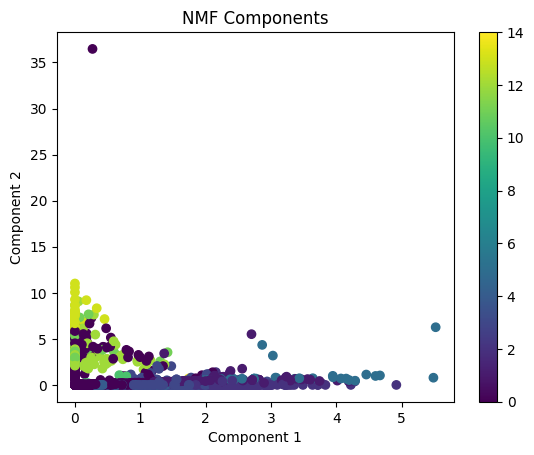

In [84]:
# Initialize NMF and fit to the data
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

# Visualize the data
plt.scatter(W[:, 0], W[:, 1], c=y)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('NMF Components')
plt.colorbar()
plt.show()

In [85]:
# Step 3: Use PyTorch MLP to classify the last column
# Preprocess the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Graph Construction from NMF

## MLP

In [86]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [87]:
X_scaled = torch.FloatTensor(X_scaled)
y = torch.LongTensor(y)

In [88]:
# Assuming X and y are already defined as PyTorch tensors
# X = features tensor
# y = labels tensor

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [89]:
print(X_train.shape)
print(X_test.shape)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

torch.Size([3044, 45])
torch.Size([761, 45])


In [90]:

# Define a simple MLP model for multi-class classification
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], 256),
            nn.ReLU(),
            nn.Linear(256, len(category_mapping))  # Adjusted for 29 classes
        )
        
    def forward(self, x):
        return self.layers(x)

# Initialize the model
model = MLP()

In [91]:
model

MLP(
  (layers): Sequential(
    (0): Linear(in_features=45, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=15, bias=True)
  )
)

In [92]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters())

In [93]:
def train():
    # Training loop
    for epoch in range(1000):  # number of epochs can be adjusted
        for batch_idx, (data, target) in enumerate(train_loader):
            # Forward pass
            output = model(data)
            loss = criterion(output, target)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

train()

Epoch 0, Loss: 0.9315474629402161
Epoch 50, Loss: 0.016080766916275024
Epoch 100, Loss: 0.007192282006144524
Epoch 150, Loss: 0.002070068381726742
Epoch 200, Loss: 0.00042656241566874087
Epoch 250, Loss: 0.012821161188185215
Epoch 300, Loss: 0.0009743166738189757
Epoch 350, Loss: 0.00033364322734996676
Epoch 400, Loss: 1.4529118743666913e-05
Epoch 450, Loss: 0.0001260733261005953
Epoch 500, Loss: 0.0021755164489150047
Epoch 550, Loss: 0.00012839688861276954
Epoch 600, Loss: 3.5960713375970954e-06
Epoch 650, Loss: 2.3146203602664173e-06
Epoch 700, Loss: 3.0288265406852588e-05
Epoch 750, Loss: 1.6887960896383447e-07
Epoch 800, Loss: 2.9966808142489754e-05
Epoch 850, Loss: 1.8620215996634215e-05
Epoch 900, Loss: 7.026680395938456e-05
Epoch 950, Loss: 1.1819095561804716e-05


In [94]:
def test():
    model.eval()
    test_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            all_targets.extend(target.tolist())
            all_predictions.extend(output.argmax(dim=1).tolist())

    test_loss /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss}")

    # Calculate F1 score
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    print(f"F1 Score: {f1}")
    
    return all_predictions, all_targets
    
pred, target = test()

Test Loss: 0.020815564609841297
F1 Score: 0.972820183087883


In [95]:
for i, j in zip(pred, target):
    print("Pred:",mapping_category[i],"\n","True:",mapping_category[j])
    print()

Pred: Agriculture Soil 
 True: Agriculture Soil

Pred: Paved Road Dust 
 True: Paved Road Dust

Pred: Motor Vehicle Exhaust 
 True: Motor Vehicle Exhaust

Pred: Paved Road Dust 
 True: Paved Road Dust

Pred: Motor Vehicle Exhaust 
 True: Motor Vehicle Exhaust

Pred: Cooking 
 True: Cooking

Pred: Motor Vehicle Exhaust 
 True: Motor Vehicle Exhaust

Pred: Residential Wood Burning 
 True: Paved Road Dust

Pred: Motor Vehicle Exhaust 
 True: Motor Vehicle Exhaust

Pred: Motor Vehicle Exhaust 
 True: Motor Vehicle Exhaust

Pred: Motor Vehicle Exhaust 
 True: Motor Vehicle Exhaust

Pred: Motor Vehicle Exhaust 
 True: Motor Vehicle Exhaust

Pred: Paved Road Dust 
 True: Paved Road Dust

Pred: Motor Vehicle Exhaust 
 True: Motor Vehicle Exhaust

Pred: Paved Road Dust 
 True: Agriculture Soil

Pred: Motor Vehicle Exhaust 
 True: Motor Vehicle Exhaust

Pred: Motor Vehicle Exhaust 
 True: Motor Vehicle Exhaust

Pred: Motor Vehicle Exhaust 
 True: Motor Vehicle Exhaust

Pred: Paved Road Dust 
 Tr